# 2025-1 Artificial Intelligence (01)
## Homework #2: CNN and Regularization
---
Copyright (c) Prof. Jaehyeong Sim

Department of Computer Science and Engineering

College of Artificial Intelligence

Ewha Womans University

## Guideline
### Introduction
*   Here in this homework, we will implement a ResNet-style CNN to peform simple object classfication using CIFAR-10 dataset in PyTorch. Also, we will perform experiments on various regularization methods.

### Your job
1. Please complete the code. You only have to write the parts marked as **# TODO**.
2. Please answer the discussion topics at the bottom of this notebook in a separate PDF file.

### Submission guide
1. Please rename the completed skeleton file to ***STUDENT_ID*.ipynb**. Your own student ID goes to *STUDENT_ID*. For example, if your student ID is 2512345, the file name should be **2512345.ipynb**. Also, make your PDF file name ***STUDENT_ID*.pdf***.
2. Turn in them into the Ewha CyberCampus.

⚠ If you doesn't follow the submission guide above, you will get **5 point deduction** from this homework score.

### Deadline
*   **May 17, 23:59**

### 1. Necessary libraries

In [ ]:
%pip install torch torchvision matplotlib numpy

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Using GPU
# Make sure you change your runtime environment of Colab to use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Dataset and DataLoader preparation
*   For augmenting images, please refer to the following documentation: https://docs.pytorch.org/vision/main/transforms.html



In [4]:
# Data augmentation: Not applied
transform_basic = transforms.Compose([
    transforms.ToTensor()
])

# Data augmentation: Random horizontal flit, Random crop
transform_aug = transforms.Compose([
    # TODO
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

# Train set (Use only 10% of the entire samples to induce overfitting)
train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_basic)
subset_size = int(0.1 * len(train_full))  # 5000 samples
train_subset = Subset(train_full, range(subset_size))
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# Test set (Use full samples)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_basic)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

100.0%


### 2-1. Dataset visualization

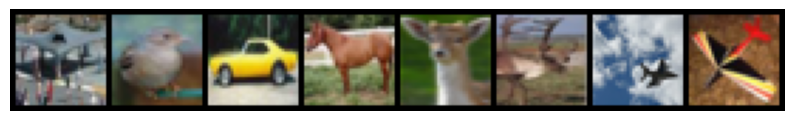

Labels: ['airplane', 'bird', 'automobile', 'horse', 'deer', 'deer', 'airplane', 'airplane']


In [10]:
# Class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Prepare one DataLoader
sample_loader = DataLoader(train_subset, batch_size=8, shuffle=True)

# Fetch a single mini-batch
images, labels = next(iter(sample_loader))

# Switch the Tensors into images
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Visualization
imshow(torchvision.utils.make_grid(images))
print('Labels:', [classes[label] for label in labels])

### 3. Implementation of ResNet block
The block is illustrated below. Make it general for different input channel size, output channel size, strides.

*   For Conv2D layer, please refer to the following documentation: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
*   For BatchNorm layer, please refer to the following documentation: https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html


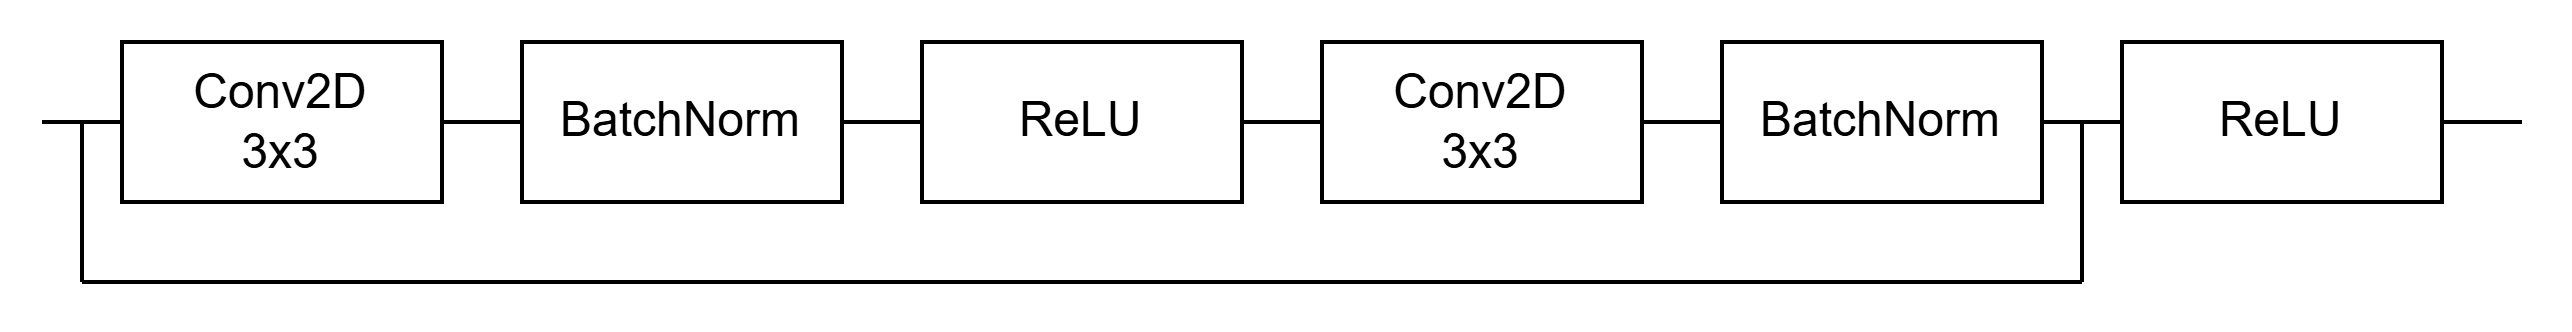

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()

        # TODO
        stride = 2 if downsample else 1
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection (shortcut)
        self.shortcut = nn.Sequential()
        
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):

        # TODO
        identity = x
        
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

### 4. Implementation of ResNet model

The model is illustrated below.

*   /2 represents downsampling by 2
*   For Average Pool layer, please refer to the following documentation: https://docs.pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
*   For Dropout layer, please refer to the following documentation:
 https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

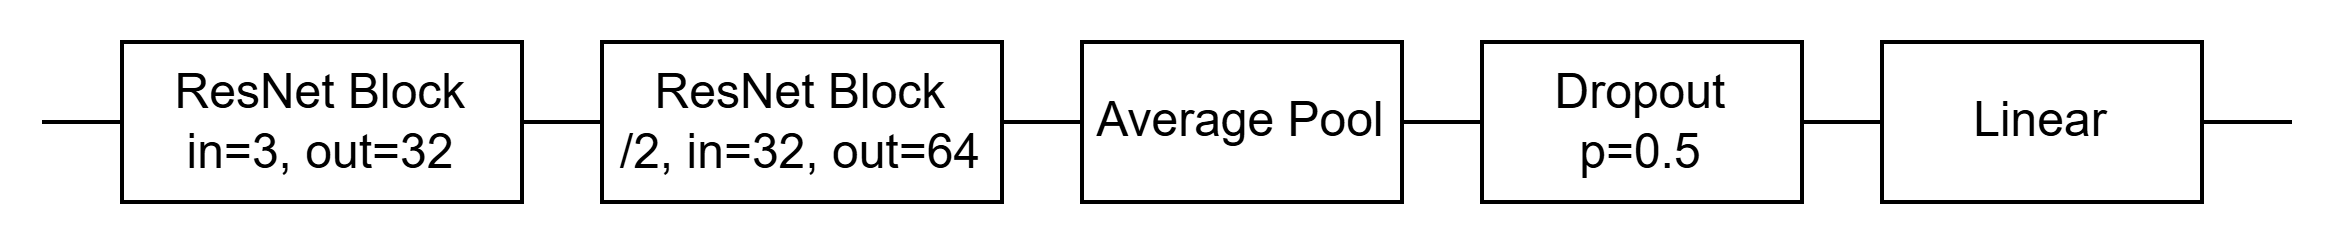



In [ ]:
class ResNetSmall(nn.Module):
    def __init__(self, dropout=False):
        super().__init__()
        
        # ResNet blocks
        self.block1 = ResidualBlock(3, 32, downsample=False)
        self.block2 = ResidualBlock(32, 64, downsample=True)
        
        # Average pooling
        self.avg_pool = nn.AvgPool2d(kernel_size=8)
        
        # Dropout
        self.use_dropout = dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(0.5)
        
        # FC Layer
        self.fc = nn.Linear(256, 10) 

    def forward(self, x):
        # ResNet blocks
        x = self.block1(x)
        x = self.block2(x)
        
        # Average pooling
        x = self.avg_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dropout
        if self.use_dropout:
            x = self.dropout(x)
        
        # FC Layer
        x = self.fc(x)
        
        return x

### 5. Implementation of train function for a single epoch

In [13]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    correct = total = 0
    loss_total = 0

    for inputs, labels in train_loader:
        # TODO
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    avg_loss = loss_total / len(train_loader)
    return avg_loss, accuracy

### 6. Evaluation using test dataset

In [14]:
def evaluate(model, test_loader, criterion):
    model.eval()
    correct = total = 0
    loss_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # TODO
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_loss = loss_total / len(test_loader)
    return avg_loss, accuracy

### 7. Run experiment

In [15]:
def run_experiment(dropout=False, use_aug=False, weight_decay=0.0, epochs=30):
    print(f"Configuration: Dropout={dropout}, Aug={use_aug}, Weight Decay={weight_decay}")

    train_data = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=False,
        transform=transform_aug if use_aug else transform_basic
    )
    train_loader = DataLoader(Subset(train_data, range(5000)), batch_size=64, shuffle=True)

    model = ResNetSmall(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Dropout={dropout}, Aug={use_aug}, Weight Decay={weight_decay}")
    plt.tight_layout()
    plt.show()

    return (train_losses[-1], test_losses[-1]), (train_accs[-1], test_accs[-1])


### 8. Actual invocation of experiments

Configuration: Dropout=False, Aug=False, Weight Decay=0.0
[Epoch 1] Train Loss: 1.8740, Acc: 0.3118 | Test Loss: 1.8005, Acc: 0.3032
[Epoch 2] Train Loss: 1.6343, Acc: 0.4084 | Test Loss: 2.0006, Acc: 0.3173
[Epoch 3] Train Loss: 1.5207, Acc: 0.4620 | Test Loss: 1.7775, Acc: 0.3566
[Epoch 4] Train Loss: 1.4272, Acc: 0.4842 | Test Loss: 1.5927, Acc: 0.4107
[Epoch 5] Train Loss: 1.3818, Acc: 0.4898 | Test Loss: 1.3638, Acc: 0.5092
[Epoch 6] Train Loss: 1.3107, Acc: 0.5242 | Test Loss: 1.5803, Acc: 0.4438
[Epoch 7] Train Loss: 1.2655, Acc: 0.5482 | Test Loss: 2.2670, Acc: 0.3524
[Epoch 8] Train Loss: 1.2462, Acc: 0.5524 | Test Loss: 1.5129, Acc: 0.4489
[Epoch 9] Train Loss: 1.2061, Acc: 0.5604 | Test Loss: 1.3552, Acc: 0.5180
[Epoch 10] Train Loss: 1.1658, Acc: 0.5892 | Test Loss: 1.5256, Acc: 0.4441
[Epoch 11] Train Loss: 1.1354, Acc: 0.5960 | Test Loss: 1.7165, Acc: 0.4154
[Epoch 12] Train Loss: 1.1192, Acc: 0.5942 | Test Loss: 1.3431, Acc: 0.5110
[Epoch 13] Train Loss: 1.0643, Acc: 0.6

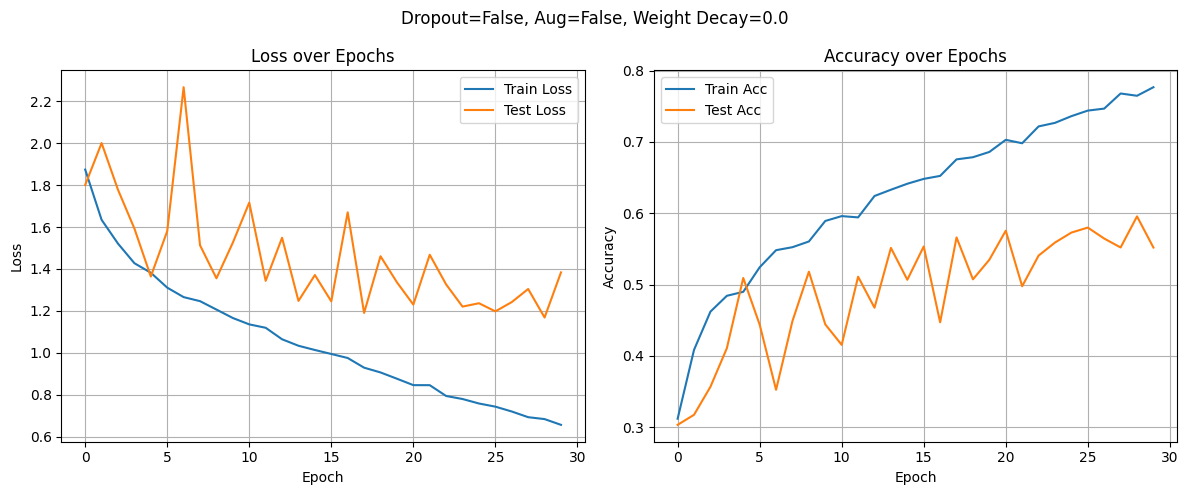

((0.6560425520697727, 1.3834537746040685), (0.7768, 0.5519))

In [ ]:
# Experiment A: Basic model (Observe overfitting)
#run_experiment(dropout=False, use_aug=False, weight_decay=0.0)

# Experiment B: Dropout only
#run_experiment(dropout=True, use_aug=False, weight_decay=0.0)

# Experiment C: Data Augmentation only
#run_experiment(dropout=False, use_aug=True, weight_decay=0.0)

# Experiment D: Dropout + Augmentation + Weight Decay
# run_experiment(dropout=True, use_aug=True, weight_decay=1e-4)

# Experiment E: Weight Decay only
# run_experiment(dropout=False, use_aug=False, weight_decay=1e-4)

### Discussion
1.   Report loss and accuracy plots for every experiment and see whether overfitting happens or not.
2.   Compare the efficacy of each regularization method.
3.   Change hyperparameters of regularization methods and compare the results.

※ Note that if you do an experiment again, you should restart the session. Otherwise, the trained model will be further trained again, giving incorrect behaviour.